In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import random

class BERTDataset(Dataset):
    def __init__(self, vocab_size=1000, seq_length=32, num_samples=1000):
        self.vocab_size = vocab_size
        self.seq_length = seq_length
        self.num_samples = num_samples
        
        # Special tokens
        self.CLS = vocab_size
        self.SEP = vocab_size + 1
        self.MASK = vocab_size + 2
        self.PAD = vocab_size + 3
        
        # Generate synthetic sentences (random token sequences)
        self.sentences = self._generate_sentences()
        
    def _generate_sentences(self):
        sentences = []
        for _ in range(self.num_samples * 2):  # Generate extra for NSP pairs
            length = random.randint(3, self.seq_length - 2)  # Leave room for CLS and SEP
            sentence = torch.randint(0, self.vocab_size, (length,))
            sentences.append(sentence)
        return sentences
    
    def _create_mlm_and_labels(self, sequence):
        labels = sequence.clone()
        # Mask 15% of tokens
        mask_prob = torch.rand(len(sequence))
        mask = mask_prob < 0.15
        
        # 80% of masked tokens become MASK token
        mask_mask = torch.rand(len(sequence)) < 0.8
        sequence[mask & mask_mask] = self.MASK
        
        # 10% of masked tokens become random tokens
        random_mask = torch.rand(len(sequence)) < 0.5
        random_tokens = torch.randint(0, self.vocab_size, (len(sequence),))
        sequence[mask & ~mask_mask & random_mask] = random_tokens[mask & ~mask_mask & random_mask]
        
        # Rest 10% remain unchanged
        return sequence, labels
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # Select first sentence
        sent1_idx = idx * 2
        sent1 = self.sentences[sent1_idx]
        
        # 50% chance of selecting next sentence, 50% chance of random sentence
        is_next = random.random() < 0.5
        if is_next:
            sent2 = self.sentences[sent1_idx + 1]
        else:
            random_idx = random.randint(0, len(self.sentences) - 1)
            while random_idx in [sent1_idx, sent1_idx + 1]:
                random_idx = random.randint(0, len(self.sentences) - 1)
            sent2 = self.sentences[random_idx]
        
        # Combine sentences with CLS and SEP tokens
        tokens = torch.cat([
            torch.tensor([self.CLS]),
            sent1,
            torch.tensor([self.SEP]),
            sent2,
            torch.tensor([self.SEP])
        ])
        
        # Pad if necessary
        if len(tokens) < self.seq_length:
            padding = torch.tensor([self.PAD] * (self.seq_length - len(tokens)))
            tokens = torch.cat([tokens, padding])
        else:
            tokens = tokens[:self.seq_length]
        
        # Create MLM task
        masked_tokens, mlm_labels = self._create_mlm_and_labels(tokens.clone())
        
        # Create segment IDs (0 for first sentence, 1 for second)
        sep_positions = (tokens == self.SEP).nonzero().flatten()
        segment_ids = torch.zeros_like(tokens)
        if len(sep_positions) > 0:
            segment_ids[sep_positions[0]+1:] = 1
        
        return {
            'input_ids': masked_tokens,
            'segment_ids': segment_ids,
            'mlm_labels': mlm_labels,
            'nsp_label': torch.tensor(1 if is_next else 0)
        }

class BERT(nn.Module):
    def __init__(self, vocab_size, hidden_size=256, num_layers=6, num_heads=8, 
                 dropout=0.1, max_seq_length=32):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Token and position embeddings
        self.token_embedding = nn.Embedding(vocab_size + 4, hidden_size)  # +4 for special tokens
        self.position_embedding = nn.Embedding(max_seq_length, hidden_size)
        self.segment_embedding = nn.Embedding(2, hidden_size)
        
        # Transformer layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=num_heads,
            dim_feedforward=hidden_size * 4,
            dropout=dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # MLM prediction head
        self.mlm_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, vocab_size + 4)  # +4 for special tokens
        )
        
        # NSP prediction head
        self.nsp_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 2)
        )
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids, segment_ids):
        batch_size, seq_length = input_ids.shape
        
        # Create position IDs
        position_ids = torch.arange(seq_length, device=input_ids.device).expand(batch_size, -1)
        
        # Get embeddings
        token_embeddings = self.token_embedding(input_ids)
        position_embeddings = self.position_embedding(position_ids)
        segment_embeddings = self.segment_embedding(segment_ids)
        
        # Combine embeddings
        embeddings = token_embeddings + position_embeddings + segment_embeddings
        embeddings = self.dropout(embeddings)
        
        # Transform
        transformer_output = self.transformer(embeddings.transpose(0, 1)).transpose(0, 1)
        
        # MLM output
        mlm_output = self.mlm_head(transformer_output)
        
        # NSP output (use [CLS] token representation)
        nsp_output = self.nsp_head(transformer_output[:, 0])
        
        return mlm_output, nsp_output

class BERTTrainer:
    def __init__(self, model, dataset, batch_size=32, learning_rate=1e-4):
        self.model = model
        self.batch_size = batch_size
        
        # Split dataset
        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        self.train_dataset, self.test_dataset = torch.utils.data.random_split(
            dataset, [train_size, test_size])
        
        self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=batch_size)
        
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        self.mlm_criterion = nn.CrossEntropyLoss(ignore_index=dataset.PAD)
        self.nsp_criterion = nn.CrossEntropyLoss()
        
        # Metrics storage
        self.train_mlm_losses = []
        self.train_nsp_losses = []
        self.test_mlm_losses = []
        self.test_nsp_losses = []
        self.mlm_accuracies = []
        self.nsp_accuracies = []
    
    def train_epoch(self):
        self.model.train()
        total_mlm_loss = 0
        total_nsp_loss = 0
        mlm_correct = 0
        nsp_correct = 0
        total_mlm_tokens = 0
        total_nsp_samples = 0
        
        for batch in self.train_loader:
            self.optimizer.zero_grad()
            
            mlm_output, nsp_output = self.model(batch['input_ids'], batch['segment_ids'])
            
            # MLM loss
            mlm_loss = self.mlm_criterion(
                mlm_output.view(-1, mlm_output.size(-1)),
                batch['mlm_labels'].view(-1)
            )
            
            # NSP loss
            nsp_loss = self.nsp_criterion(nsp_output, batch['nsp_label'])
            
            # Combined loss
            loss = mlm_loss + nsp_loss
            loss.backward()
            self.optimizer.step()
            
            # Calculate accuracies
            mlm_pred = mlm_output.argmax(dim=-1)
            mlm_correct += (mlm_pred == batch['mlm_labels'])[batch['mlm_labels'] != self.train_dataset.dataset.PAD].sum().item()
            total_mlm_tokens += (batch['mlm_labels'] != self.train_dataset.dataset.PAD).sum().item()
            
            nsp_pred = nsp_output.argmax(dim=-1)
            nsp_correct += (nsp_pred == batch['nsp_label']).sum().item()
            total_nsp_samples += len(batch['nsp_label'])
            
            total_mlm_loss += mlm_loss.item()
            total_nsp_loss += nsp_loss.item()
        
        avg_mlm_loss = total_mlm_loss / len(self.train_loader)
        avg_nsp_loss = total_nsp_loss / len(self.train_loader)
        mlm_accuracy = mlm_correct / total_mlm_tokens
        nsp_accuracy = nsp_correct / total_nsp_samples
        
        self.train_mlm_losses.append(avg_mlm_loss)
        self.train_nsp_losses.append(avg_nsp_loss)
        self.mlm_accuracies.append(mlm_accuracy)
        self.nsp_accuracies.append(nsp_accuracy)
        
        return avg_mlm_loss, avg_nsp_loss, mlm_accuracy, nsp_accuracy

def train_and_visualize_bert():
    # Initialize dataset and model
    vocab_size = 1000
    hidden_size = 256
    num_layers = 6
    num_heads = 8
    batch_size = 32
    num_epochs = 10
    
    dataset = BERTDataset(vocab_size=vocab_size)
    model = BERT(vocab_size=vocab_size, hidden_size=hidden_size, 
                 num_layers=num_layers, num_heads=num_heads)
    
    trainer = BERTTrainer(model, dataset, batch_size=batch_size)
    
    # Training loop
    for epoch in range(num_epochs):
        mlm_loss, nsp_loss, mlm_acc, nsp_acc = trainer.train_epoch()
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"MLM Loss: {mlm_loss:.4f}, NSP Loss: {nsp_loss:.4f}")
        print(f"MLM Accuracy: {mlm_acc:.4f}, NSP Accuracy: {nsp_acc:.4f}")
        print("-" * 50)

if __name__ == "__main__":
    train_and_visualize_bert()

c:\Users\a4446\AppData\Local\miniconda3\envs\llm\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10
MLM Loss: 6.7484, NSP Loss: 0.7016
MLM Accuracy: 0.0684, NSP Accuracy: 0.5038
--------------------------------------------------
Epoch 2/10
MLM Loss: 6.4588, NSP Loss: 0.7058
MLM Accuracy: 0.0812, NSP Accuracy: 0.4975
--------------------------------------------------
Epoch 3/10
MLM Loss: 6.1846, NSP Loss: 0.7014
MLM Accuracy: 0.0852, NSP Accuracy: 0.4975
--------------------------------------------------
Epoch 4/10
MLM Loss: 5.8895, NSP Loss: 0.6968
MLM Accuracy: 0.1089, NSP Accuracy: 0.5162
--------------------------------------------------
Epoch 5/10
MLM Loss: 5.5666, NSP Loss: 0.7079
MLM Accuracy: 0.1774, NSP Accuracy: 0.4913
--------------------------------------------------
Epoch 6/10
MLM Loss: 5.2203, NSP Loss: 0.6955
MLM Accuracy: 0.2995, NSP Accuracy: 0.5175
--------------------------------------------------
Epoch 7/10
MLM Loss: 4.9095, NSP Loss: 0.7038
MLM Accuracy: 0.4389, NSP Accuracy: 0.4850
--------------------------------------------------
Epoch 8/10
MLM Loss:

c:\Users\a4446\AppData\Local\miniconda3\envs\llm\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10
MLM Loss: 6.7811, NSP Loss: 0.7063
MLM Accuracy: 0.0697, NSP Accuracy: 0.5050
--------------------------------------------------
Epoch 2/10
MLM Loss: 6.4937, NSP Loss: 0.7037
MLM Accuracy: 0.0801, NSP Accuracy: 0.4900
--------------------------------------------------
Epoch 3/10
MLM Loss: 6.1995, NSP Loss: 0.6963
MLM Accuracy: 0.0854, NSP Accuracy: 0.5038
--------------------------------------------------
Epoch 4/10
MLM Loss: 5.8861, NSP Loss: 0.6988
MLM Accuracy: 0.1072, NSP Accuracy: 0.5312
--------------------------------------------------
Epoch 5/10
MLM Loss: 5.5370, NSP Loss: 0.6979
MLM Accuracy: 0.1802, NSP Accuracy: 0.5000
--------------------------------------------------


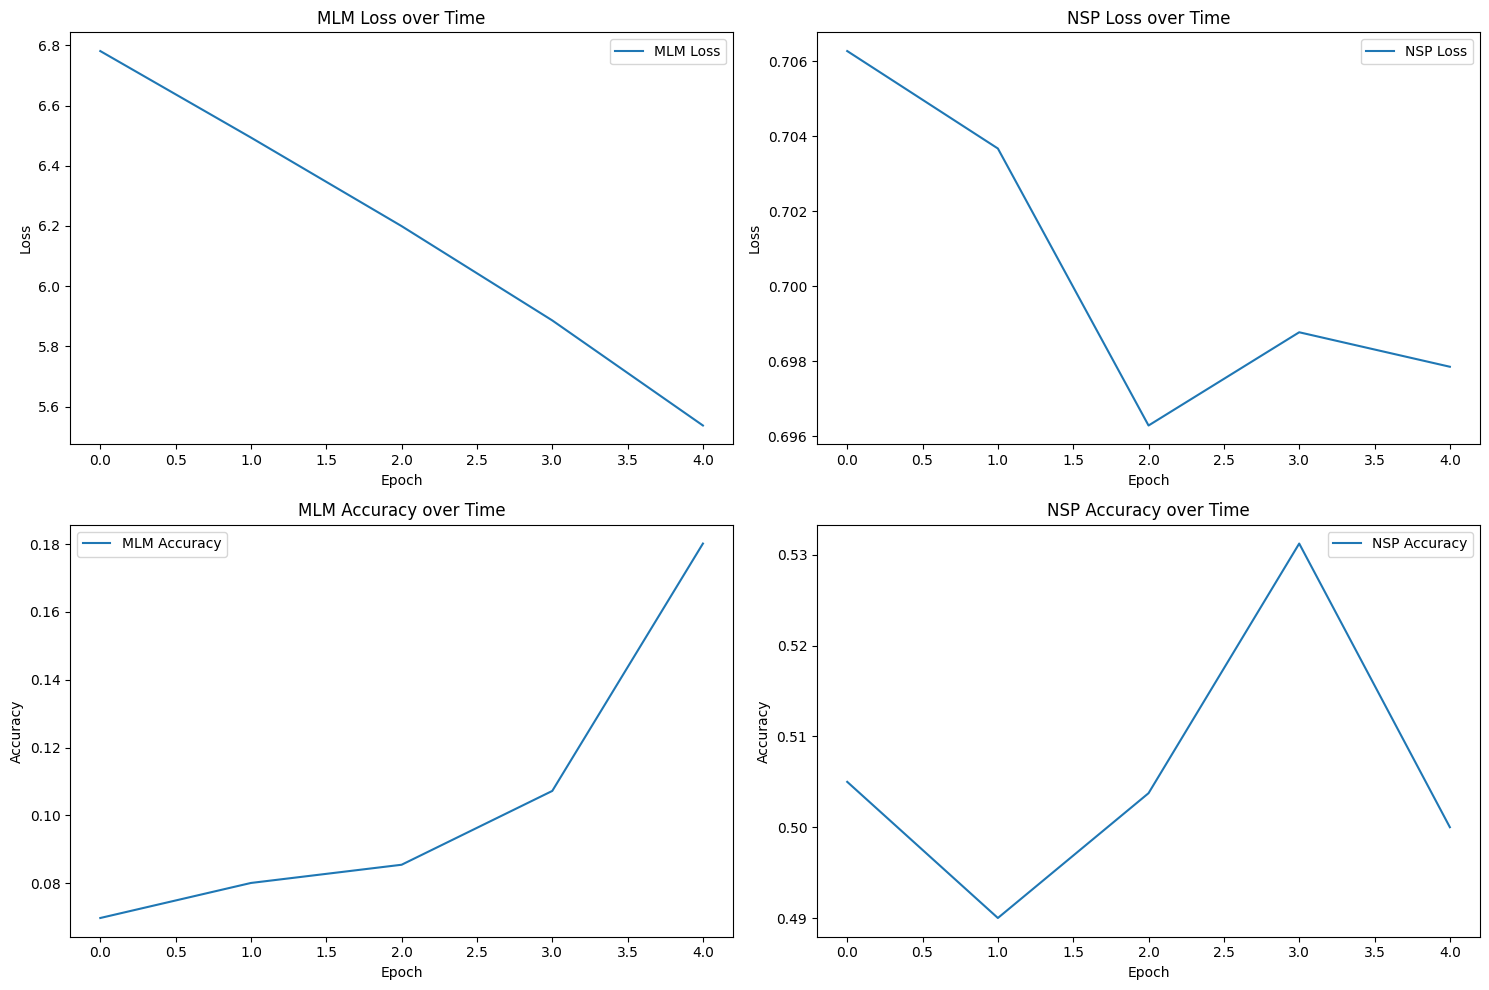

Epoch 6/10
MLM Loss: 5.2093, NSP Loss: 0.7035
MLM Accuracy: 0.2959, NSP Accuracy: 0.4913
--------------------------------------------------
Epoch 7/10
MLM Loss: 4.8803, NSP Loss: 0.7014
MLM Accuracy: 0.4406, NSP Accuracy: 0.4888
--------------------------------------------------
Epoch 8/10
MLM Loss: 4.5845, NSP Loss: 0.6978
MLM Accuracy: 0.5717, NSP Accuracy: 0.5200
--------------------------------------------------
Epoch 9/10
MLM Loss: 4.2953, NSP Loss: 0.6975
MLM Accuracy: 0.6730, NSP Accuracy: 0.5000
--------------------------------------------------
Epoch 10/10
MLM Loss: 3.9918, NSP Loss: 0.7007
MLM Accuracy: 0.7532, NSP Accuracy: 0.4900
--------------------------------------------------


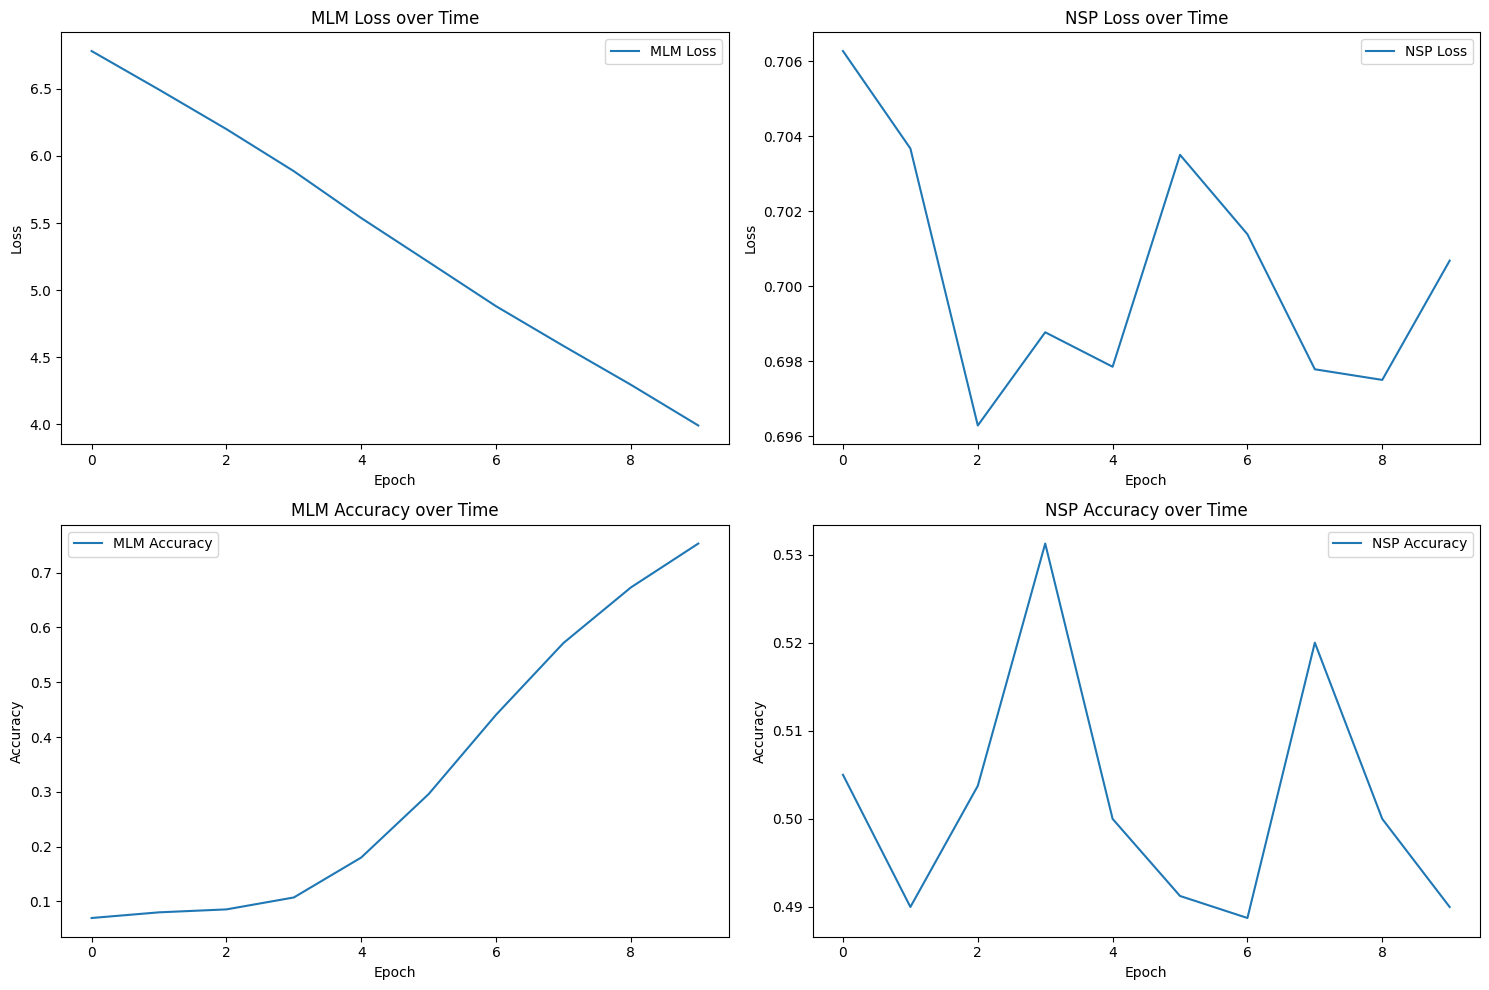


Final Model Analysis:


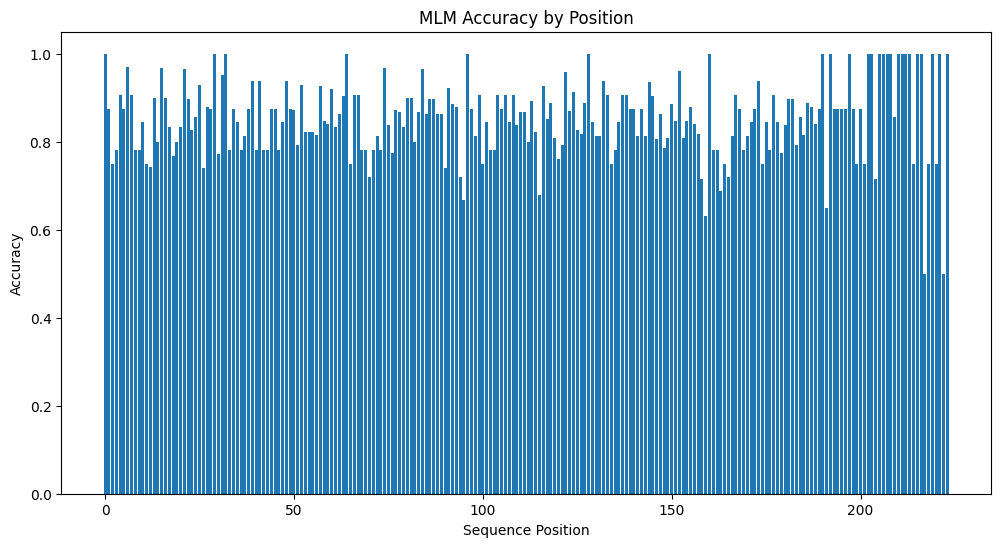

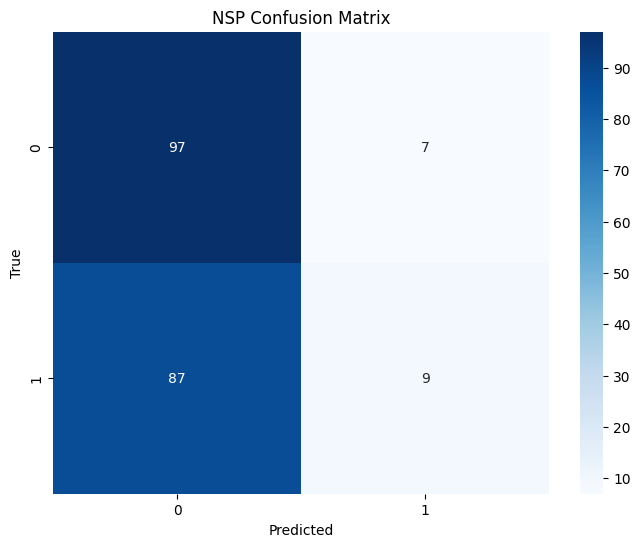


Visualization of Token Embeddings:


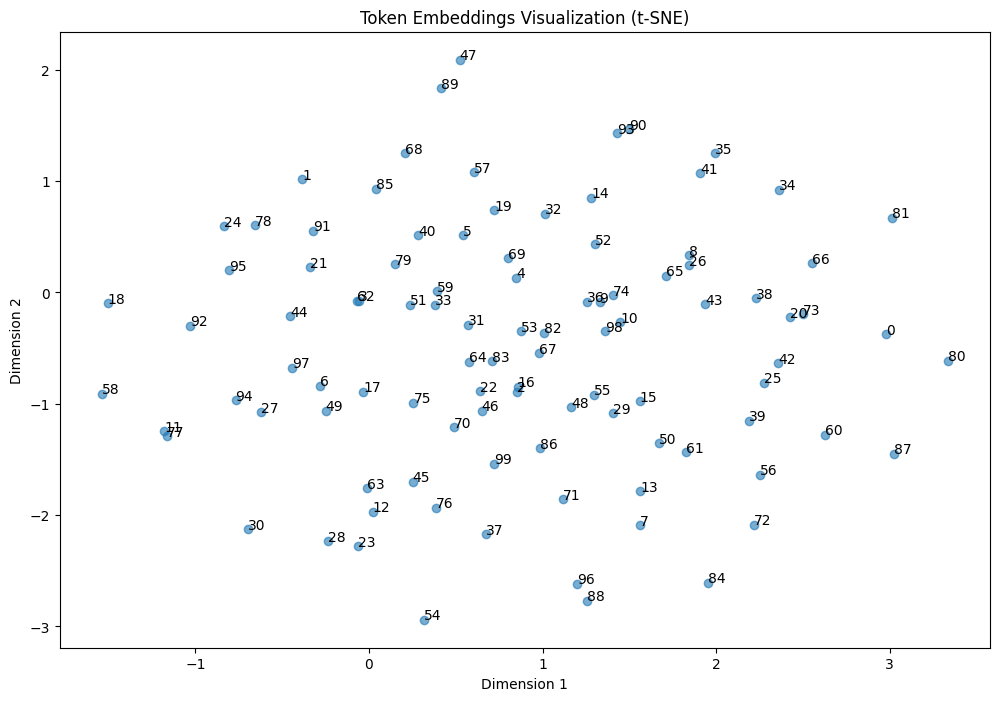


Example Predictions:

Example 1:

Input Sequence:
[CLS] 699 210 629 259 880 [MASK] [SEP] 397 173 92 [MASK] 831 982 892 158 376 [MASK] 473 776 957 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [MASK] [MASK] [PAD]

Masked Language Modeling:
Position 6:
  True token: 871
  Predicted: [SEP]
Position 11:
  True token: 183
  Predicted: [SEP]
Position 17:
  True token: 703
  Predicted: [SEP]
Position 29:
  True token: [PAD]
  Predicted: [SEP]
Position 30:
  True token: [PAD]
  Predicted: [SEP]

Next Sentence Prediction:
True label: Unrelated
Predicted: Unrelated

Example 2:

Input Sequence:
[CLS] 630 [MASK] 232 679 491 121 [MASK] 66 719 156 172 3 169 873 614 259 759 948 141 [MASK] 80 502 [SEP] 552 500 181 [MASK] 330 808 917 193

Masked Language Modeling:
Position 2:
  True token: 443
  Predicted: [SEP]
Position 7:
  True token: 989
  Predicted: [SEP]
Position 20:
  True token: 516
  Predicted: [SEP]
Position 27:
  True token: 575
  Predicted: [SEP]

Next Sentence Prediction:
True label: Un

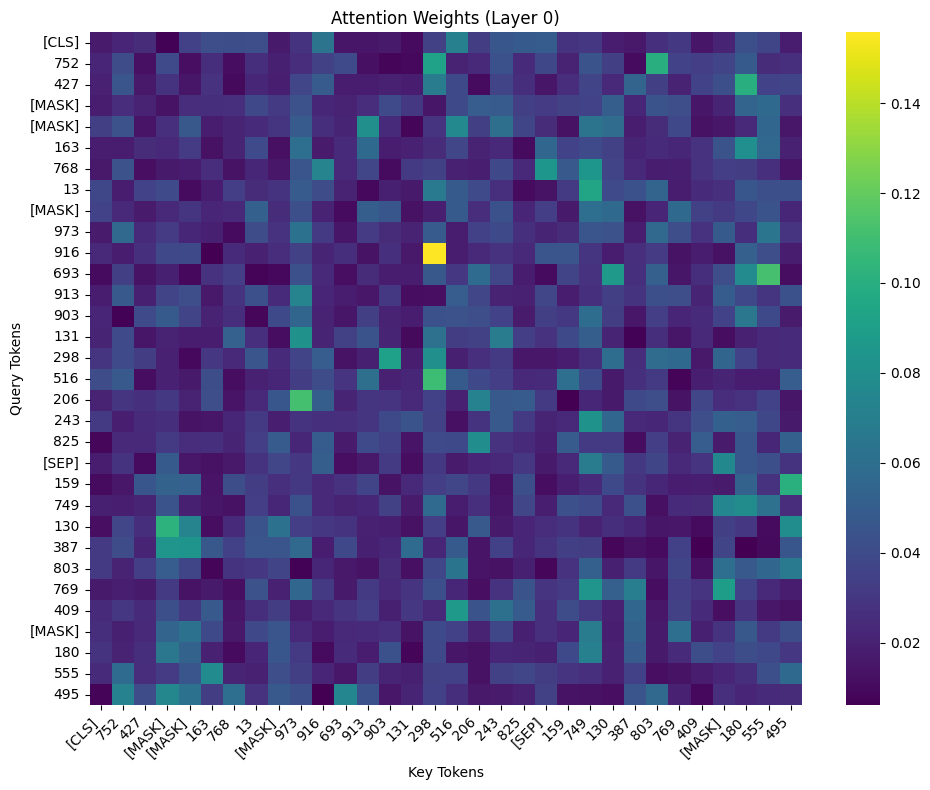

Attention visualization successful!


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

class BERTVisualizer:
    def __init__(self, trainer):
        self.trainer = trainer
    
    def plot_training_metrics(self):
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot MLM loss
        ax1.plot(self.trainer.train_mlm_losses, label='MLM Loss')
        ax1.set_title('MLM Loss over Time')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        # Plot NSP loss
        ax2.plot(self.trainer.train_nsp_losses, label='NSP Loss')
        ax2.set_title('NSP Loss over Time')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        
        # Plot MLM accuracy
        ax3.plot(self.trainer.mlm_accuracies, label='MLM Accuracy')
        ax3.set_title('MLM Accuracy over Time')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Accuracy')
        ax3.legend()
        
        # Plot NSP accuracy
        ax4.plot(self.trainer.nsp_accuracies, label='NSP Accuracy')
        ax4.set_title('NSP Accuracy over Time')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Accuracy')
        ax4.legend()
        
        plt.tight_layout()
        plt.show()
        
    def visualize_attention(self, input_ids, segment_ids, layer_idx=-1):
        self.trainer.model.eval()
        
        # Create a custom attention layer that returns attention weights
        class AttentionWithWeights(nn.MultiheadAttention):
            def forward(self, query, key, value, key_padding_mask=None,
                      need_weights=True, attn_mask=None):
                output, attention = super().forward(query, key, value, 
                                                  key_padding_mask=key_padding_mask,
                                                  need_weights=need_weights,
                                                  attn_mask=attn_mask)
                return output, attention

        # Replace the attention layer with our custom one
        original_attention = self.trainer.model.transformer.layers[layer_idx].self_attn
        self.trainer.model.transformer.layers[layer_idx].self_attn = AttentionWithWeights(
            embed_dim=original_attention.embed_dim,
            num_heads=original_attention.num_heads,
            dropout=original_attention.dropout,
            bias=True,
            add_bias_kv=False,
            add_zero_attn=False,
            kdim=None,
            vdim=None
        )
        
        # Forward pass
        with torch.no_grad():
            # Get embeddings
            batch_size, seq_length = input_ids.shape
            position_ids = torch.arange(seq_length, device=input_ids.device).expand(batch_size, -1)
            
            token_embeddings = self.trainer.model.token_embedding(input_ids)
            position_embeddings = self.trainer.model.position_embedding(position_ids)
            segment_embeddings = self.trainer.model.segment_embedding(segment_ids)
            
            embeddings = token_embeddings + position_embeddings + segment_embeddings
            embeddings = embeddings.transpose(0, 1)  # [seq_length, batch_size, hidden_size]
            
            # Run through transformer layers up to the target layer
            for i in range(layer_idx):
                embeddings = self.trainer.model.transformer.layers[i](embeddings)
            
            # Get attention weights from target layer
            attn_output, attn_weights = self.trainer.model.transformer.layers[layer_idx].self_attn(
                embeddings, embeddings, embeddings, need_weights=True
            )
        
        # Restore original attention layer
        self.trainer.model.transformer.layers[layer_idx].self_attn = original_attention
        
        # Process attention weights
        attn_weights = attn_weights.cpu().numpy()  # [batch_size, seq_length, seq_length]
        
        # Plot attention heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(attn_weights[0], cmap='viridis')
        plt.title(f'Attention Weights (Layer {layer_idx})')
        plt.xlabel('Key Tokens')
        plt.ylabel('Query Tokens')
        
        # Add token labels
        token_labels = [self._token_to_str(tid) for tid in input_ids[0]]
        plt.xticks(np.arange(len(token_labels)) + 0.5, token_labels, rotation=45, ha='right')
        plt.yticks(np.arange(len(token_labels)) + 0.5, token_labels, rotation=0)
        
        plt.tight_layout()
        plt.show()

    def _token_to_str(self, token_id):
        if token_id == self.trainer.train_dataset.dataset.MASK:
            return "[MASK]"
        elif token_id == self.trainer.train_dataset.dataset.CLS:
            return "[CLS]"
        elif token_id == self.trainer.train_dataset.dataset.SEP:
            return "[SEP]"
        elif token_id == self.trainer.train_dataset.dataset.PAD:
            return "[PAD]"
        else:
            return str(token_id.item())
    
    def visualize_predictions(self, num_examples=5):
        self.trainer.model.eval()
        
        for i, batch in enumerate(self.trainer.test_loader):
            if i >= num_examples:
                break
                
            with torch.no_grad():
                mlm_output, nsp_output = self.trainer.model(batch['input_ids'], batch['segment_ids'])
                
                # Get predictions
                mlm_pred = mlm_output.argmax(dim=-1)
                nsp_pred = nsp_output.argmax(dim=-1)
                
                # Visualize for first sequence in batch
                print(f"\nExample {i+1}:")
                self._visualize_single_prediction(
                    batch['input_ids'][0],
                    batch['mlm_labels'][0],
                    mlm_pred[0],
                    batch['nsp_label'][0],
                    nsp_pred[0]
                )
    
    def _visualize_single_prediction(self, input_ids, mlm_labels, mlm_pred, nsp_label, nsp_pred):
        # Convert special token IDs to readable format
        def token_to_str(token_id):
            if token_id == self.trainer.train_dataset.dataset.MASK:
                return "[MASK]"
            elif token_id == self.trainer.train_dataset.dataset.CLS:
                return "[CLS]"
            elif token_id == self.trainer.train_dataset.dataset.SEP:
                return "[SEP]"
            elif token_id == self.trainer.train_dataset.dataset.PAD:
                return "[PAD]"
            else:
                return str(token_id.item())
        
        # Print sequence information
        print("\nInput Sequence:")
        print(" ".join(token_to_str(tid) for tid in input_ids))
        
        print("\nMasked Language Modeling:")
        for i, (inp, label, pred) in enumerate(zip(input_ids, mlm_labels, mlm_pred)):
            if inp == self.trainer.train_dataset.dataset.MASK:
                print(f"Position {i}:")
                print(f"  True token: {token_to_str(label)}")
                print(f"  Predicted: {token_to_str(pred)}")
        
        print("\nNext Sentence Prediction:")
        print(f"True label: {'Related' if nsp_label.item() == 1 else 'Unrelated'}")
        print(f"Predicted: {'Related' if nsp_pred.item() == 1 else 'Unrelated'}")
    
    def plot_token_embeddings(self, num_tokens=100):
        """Visualize token embeddings using t-SNE"""
        from sklearn.manifold import TSNE
        
        # Get embeddings for first num_tokens tokens
        embeddings = self.trainer.model.token_embedding.weight[:num_tokens].detach().cpu().numpy()
        
        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        embeddings_2d = tsne.fit_transform(embeddings)
        
        # Plot
        plt.figure(figsize=(12, 8))
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6)
        
        # Add token labels
        for i in range(num_tokens):
            plt.annotate(str(i), (embeddings_2d[i, 0], embeddings_2d[i, 1]))
        
        plt.title('Token Embeddings Visualization (t-SNE)')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.show()
    
    def analyze_model_performance(self):
        """Analyze and visualize detailed model performance metrics"""
        # Calculate performance metrics per position
        position_mlm_accuracy = []
        position_counts = []
        
        self.trainer.model.eval()
        with torch.no_grad():
            for batch in self.trainer.test_loader:
                mlm_output, _ = self.trainer.model(batch['input_ids'], batch['segment_ids'])
                mlm_pred = mlm_output.argmax(dim=-1)
                
                for pos in range(batch['input_ids'].size(1)):
                    mask = batch['mlm_labels'][:, pos] != self.trainer.train_dataset.dataset.PAD
                    if mask.sum() > 0:
                        accuracy = (mlm_pred[:, pos][mask] == batch['mlm_labels'][:, pos][mask]).float().mean()
                        position_mlm_accuracy.append(accuracy.item())
                        position_counts.append(mask.sum().item())
        
        # Plot position-wise accuracy
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(position_mlm_accuracy)), position_mlm_accuracy)
        plt.title('MLM Accuracy by Position')
        plt.xlabel('Sequence Position')
        plt.ylabel('Accuracy')
        plt.show()
        
        # Plot confusion matrix for NSP
        from sklearn.metrics import confusion_matrix
        import seaborn as sns
        
        all_nsp_preds = []
        all_nsp_labels = []
        
        with torch.no_grad():
            for batch in self.trainer.test_loader:
                _, nsp_output = self.trainer.model(batch['input_ids'], batch['segment_ids'])
                nsp_pred = nsp_output.argmax(dim=-1)
                
                all_nsp_preds.extend(nsp_pred.cpu().numpy())
                all_nsp_labels.extend(batch['nsp_label'].cpu().numpy())
        
        cm = confusion_matrix(all_nsp_labels, all_nsp_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('NSP Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

def extended_train_and_visualize_bert():
    # Initialize components
    vocab_size = 1000
    hidden_size = 256
    num_layers = 6
    num_heads = 8
    batch_size = 32
    num_epochs = 10
    
    dataset = BERTDataset(vocab_size=vocab_size)
    model = BERT(vocab_size=vocab_size, hidden_size=hidden_size, 
                 num_layers=num_layers, num_heads=num_heads)
    
    trainer = BERTTrainer(model, dataset, batch_size=batch_size)
    visualizer = BERTVisualizer(trainer)

    
    # Training loop with visualization
    for epoch in range(num_epochs):
        mlm_loss, nsp_loss, mlm_acc, nsp_acc = trainer.train_epoch()
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"MLM Loss: {mlm_loss:.4f}, NSP Loss: {nsp_loss:.4f}")
        print(f"MLM Accuracy: {mlm_acc:.4f}, NSP Accuracy: {nsp_acc:.4f}")
        print("-" * 50)
        
        # Plot metrics every few epochs
        if (epoch + 1) % 5 == 0:
            visualizer.plot_training_metrics()
    
    # Final analysis
    print("\nFinal Model Analysis:")
    visualizer.analyze_model_performance()
    
    print("\nVisualization of Token Embeddings:")
    visualizer.plot_token_embeddings()
    
    print("\nExample Predictions:")
    visualizer.visualize_predictions(num_examples=3)
    
    print("\nAttention Visualization:")
    # Get a sample batch
    sample_batch = next(iter(trainer.train_loader))
    
    # Test attention visualization
    print("Testing attention visualization...")
    try:
        visualizer.visualize_attention(
            sample_batch['input_ids'],
            sample_batch['segment_ids'],
            layer_idx=0  # First layer for testing
        )
        print("Attention visualization successful!")
    except Exception as e:
        print(f"Error during visualization: {e}")

if __name__ == "__main__":
    extended_train_and_visualize_bert()